# Synchornization in complete networks of neurons
Here is the equation of neurons potentails dynamics:
$$
\dot{v_i}=a_i - v_i - \frac{g}{N} \sum_{n|t_n<t} S_{i,l(n)} \delta(t - t_n - t_d) 
$$

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Constants and parameters:

In [2]:
num_neurons = 1000
g = 5
random_input_span = (1.2,2.8)

total_time = 1000
time_step = 0.01
total_steps = int(total_time/time_step)
time_span = np.arange(0,total_time,time_step)

delay_time = 0.1
delay_step = int(delay_time/time_step)

potentail_arr = np.zeros(num_neurons,dtype = float)
random_input = np.random.uniform(*random_input_span,size = num_neurons)

In [3]:
spiking_records = np.array( np.zeros((total_steps,num_neurons)), dtype = bool )

In [4]:
saving_path_name = 'single_runs'
current_version = 'N{}_T{}_g{}_input_{}_{}'.format(num_neurons,total_time,g,random_input_span[0],random_input_span[1])
try:
    saving_path = os.path.join(saving_path_name, current_version) 
    os.makedirs(saving_path)
except:
    pass

## Instrumentes to capture spiking frequency
Here we use *cornometer* and number of spikies to measure their frequencies.

In [5]:
spiking_cornometer = np.zeros(num_neurons)
total_spikes_intervals = np.zeros(num_neurons)
total_spikes_num = np.zeros(num_neurons)

### Useful functions:

In [6]:
def retarded_spikes_record(step):
    """
    This is the function which take cares of response delay between spikes and their effects.
    """
    if step > delay_step: 
        return np.sum(spiking_records[step - delay_step])
    else:
        return 0

## Solving the differential equation

In [7]:
for i in tqdm( range(total_steps) ):
    potentail_arr = potentail_arr + (random_input - potentail_arr)*time_step - (g/num_neurons)*retarded_spikes_record(i)
    spiking_records[i] = potentail_arr > 1
    potentail_arr = potentail_arr - 1 * spiking_records[i]
    #frequency calculator
    total_spikes_num = total_spikes_num + spiking_records[i]
    total_spikes_intervals = total_spikes_intervals + spiking_cornometer * spiking_records[i] #add to spike lapsed time
    spiking_cornometer = spiking_cornometer * (spiking_records[i]-1)*(-1) #reset the spikied cornos
    spiking_cornometer = spiking_cornometer + (spiking_records[i]-1)*(-1) #update the not spikied ones

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 26003.31it/s]


(array([ 79.,  75.,  73.,  83., 115., 114., 100., 110., 139., 112.]),
 array([7.10963672e-04, 1.00558263e-01, 2.00405563e-01, 3.00252862e-01,
        4.00100161e-01, 4.99947461e-01, 5.99794760e-01, 6.99642060e-01,
        7.99489359e-01, 8.99336659e-01, 9.99183958e-01]),
 <a list of 10 Patch objects>)

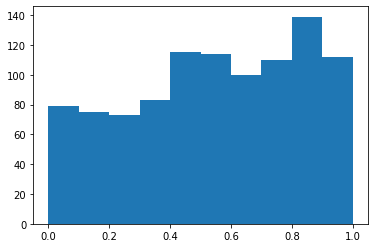

In [8]:
plt.hist(potentail_arr)

# Measuring E (effective field):
we can measure if the total network is synchronized. let's define E as following:

$$
\ddot{E}+ 2\alpha \dot{E}+\alpha^{2}E =\frac{\alpha^{2}}{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
$$

To do so, we define $M$ as $M = \dot{E} + \alpha E$. As a result we wil have the following systems of equation:
\begin{equation}
    \begin{cases}
      \dot{E} = M - \alpha E\\
      \dot{M} = -  \alpha M + \frac{ \alpha^{2} }{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
    \end{cases}\,.
\end{equation}


In [9]:
alpha = 20
m_arr = np.zeros(total_steps)
e_arr = np.zeros(total_steps)

In [10]:
for i in tqdm(range(0,total_steps-1)):
    m_arr[i+1] = m_arr[i] + time_step*( -alpha*m_arr[i] ) + ( (alpha**2)/num_neurons ) *retarded_spikes_record(i) 
    e_arr[i+1] = e_arr[i] + time_step*( m_arr[i] - alpha*e_arr[i] )

100%|█████████████████████████████████████████████████████████████████████████| 99999/99999 [00:01<00:00, 85767.67it/s]


Text(0.5, 1.0, 'E')

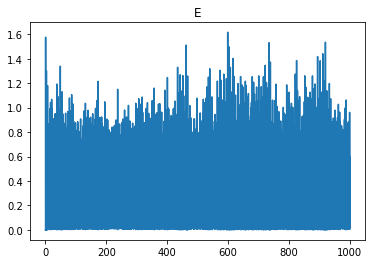

In [11]:
plt.plot(time_span,e_arr)
plt.title('E')

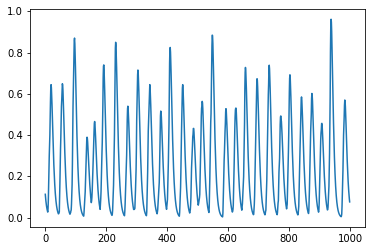

In [12]:
plt.plot(e_arr[-1000:])

In [13]:
sigma = np.std( e_arr )
sigma

0.23117392007694285

# Rasterplot

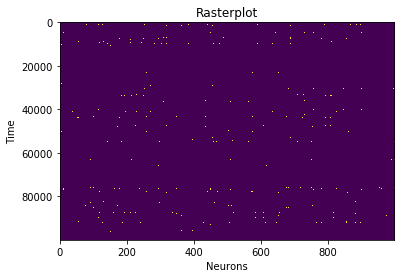

In [14]:
plt.imshow( spiking_records,aspect= 'auto')
plt.xlabel('Neurons')
plt.ylabel('Time')
plt.title('Rasterplot')
# plt.savefig('raster_plot_N{}.png'.format(num_neurons))
plt.savefig(os.path.join(saving_path, 'raster_plot.png'))

In [15]:
spiking_records

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

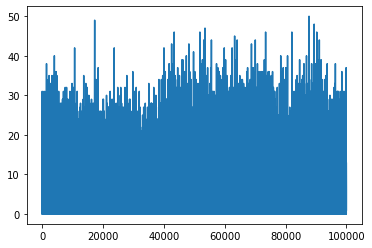

In [16]:
plt.plot(np.sum( spiking_records, axis = 1))

## Calculate frequency

In [17]:
spikies_freq_neurons = total_spikes_intervals * time_step / total_spikes_num
spikies_freq_neurons

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 13.52342466,          nan,          nan,   1.9415625 ,
         1.0230062 ,   1.0433509 ,          nan,          nan,
                nan,          nan,   1.11962712,          nan,
                nan,          nan,   2.07605428,   1.4175    ,
                nan,   3.64285714,          nan,          nan,
                nan,   1.38467225,   1.32401869,          nan,
                nan,          nan,          nan,   1.40535411,
                nan,          nan,          nan,          nan,
         2.89197674,   1.85721495,          nan,          nan,
                nan,   1.4175    ,          nan,   1.1752669 ,
                nan,   1.04673362, 229.935     ,   1.04148265,
         1.53826357,   1.41343305,          nan,          nan,
         4.71620853,          nan,          nan,          nan,
         1.29160156,   2.16165217,   4.98625   ,   1.0938232 ,
                nan,   1.72555556,          nan,          nan,
                nan,          nan,   1.21114914,       

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([426.,   1.,   0.,   3.,   0.,   2.,   0.,   0.,   0.,   4.]),
 array([  0.99623364,  60.77161027, 120.54698691, 180.32236354,
        240.09774018, 299.87311682, 359.64849345, 419.42387009,
        479.19924673, 538.97462336, 598.75      ]),
 <a list of 10 Patch objects>)

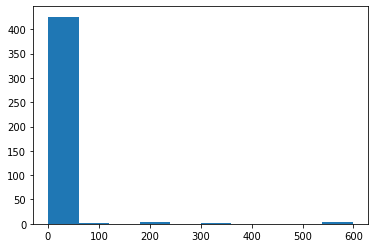

In [18]:
plt.hist(spikies_freq_neurons)